In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
from collections import OrderedDict
from tqdm import tqdm

In [80]:
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [81]:
from model_v2 import *
from data_gen import *

In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Gen

In [83]:
def checkTensorClose(tensor1, tensor2, atol):
    val_close = torch.sum(torch.isclose(tensor1, tensor2, atol=atol))
    bool_val = torch.sum(val_close) == torch.numel(tensor1)
    return bool_val.item()

In [103]:
X_train, y_train = get_train_data([5000, 5000])
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()
# X_train2, y_train2 = X_train1.clone(), y_train1.clone()

# with torch.no_grad():
#     X_mean1 = torch.mean(X_train1[:,:2], dim=0)
#     X_std1 = torch.std(X_train1[:,:2], dim=0)
#     y_mean1 = torch.mean(y_train1)
#     y_std1 = torch.std(y_train1)

#     X_train1[:,:2] -= X_mean1
#     X_train1[:,:2] /= X_std1

# y_train1 -= y_mean1
# y_train1 /= y_std1
# y_train1 = y_train1.view(-1, 1)

# X_train2[:,:2] = nn.BatchNorm1d(2, affine=False)(X_train2[:,:2])
# y_train2 = nn.BatchNorm1d(1, affine=False)(y_train2.view(-1, 1))
# y_train2 = y_train2

# Change this to change which normalization method to use.

print(X_train)
print(y_train)

train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])

# print(checkTensorClose(X_train1, X_train2, 1e-3))
# print(checkTensorClose(y_train1, y_train2, 1e-3))

tensor([[-0.5259, -1.3897,  0.0000],
        [-1.5392,  1.2976,  0.0000],
        [-1.5255,  0.0599,  0.0000],
        ...,
        [ 1.1650, -0.3919,  1.0000],
        [-0.2858,  1.2084,  1.0000],
        [ 1.2483, -0.6177,  1.0000]])
tensor([[ 0.1699],
        [ 0.9778],
        [ 0.3495],
        ...,
        [-1.0699],
        [-1.1303],
        [-1.0627]])


In [104]:
# This allows you to look into trainloader and the data returned.

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=64)
i1, l1 = next(iter(trainloader))
print(torch.max(X_train))
print(torch.min(X_train))
print(torch.max(y_train))
print(torch.min(y_train))

tensor(1.7260)
tensor(-1.7439)
tensor(2.5022)
tensor(-2.4936)


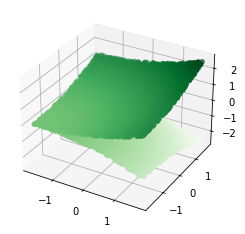

In [105]:
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:,0], X_train[:,1], y_train, c=y_train, cmap='Greens');

## Model

In [106]:
emb_dims = [2,10]

# Always keep batch size in powers of 2, trainloader is faster this way.
batch_size = 128
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
num_batches = math.ceil(1.0 * len(train_data) / batch_size)

In [107]:
# Use dropout of at least 0.1, maximum of 0.5
model = WangNet(emb_dims=emb_dims, no_of_cont=2, lin_layer_sizes=[8, 16, 32, 16, 8, 4], output_size=1, hidden_drop_p=0, batch_flag=False)

n_epochs = 50
loss_values = []
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

t = tqdm(range(n_epochs), miniters=100)
for epoch in t:
    total_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        cont_x = inputs[:,:2].float()
        cat_x = inputs[:,2].long()
        preds = model(cont_x, cat_x)
        # loss = criterion(preds, nn.BatchNorm1d(1, affine=False)(labels.view(-1,1)))

        loss = criterion(preds, labels)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    t.set_description(f"----- Epoch: {epoch}/{n_epochs} Loss: {total_loss/num_batches} -----")
    loss_values.append(total_loss/num_batches)

----- Epoch: 49/50 Loss: 0.0019856187282130122 -----: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


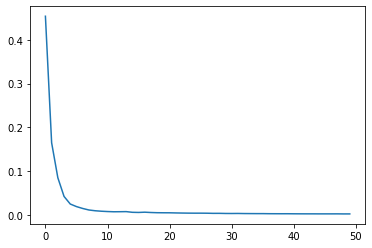

In [108]:
plt.plot(np.array(np.arange(0, n_epochs)), loss_values)

In [72]:
X_train[0]

tensor([ 0.3310, -0.4626,  0.0000])

In [78]:
cont_x_test = torch.tensor([0.3310, -0.4626])
cat_x_test = torch.tensor([0.000])

print(cont_x_test.view(-1,1).shape)
print(cat_x_test.shape)

model(torch.tensor([0.3310, -0.4626]).view(1,-1), torch.tensor([0.000]))

torch.Size([2, 1])
torch.Size([1])


tensor([[0.6819]], grad_fn=<AddmmBackward>)

In [84]:
y_std.item() * 0.6819 + y_mean.item()

13.288389037540554

In [89]:
X_std * torch.tensor([0.3310, -0.4626]) + X_mean

tensor([2.9604, 1.8218])

In [87]:
X_mean

tensor([2.4835, 2.4868])